In [ ]:
# pip install -r requirements.txt

# Feature Selection

A etapa de seleção de características (feature selection) é um processo crítico no desenvolvimento de modelos de Machine Learning. Sua importância pode ser destacada em vários aspectos: <br>

- Melhoria do Desempenho do Modelo <br>
- Redução de Overfitting <br>
- Redução do Tempo de Treinamento <br>
- Interpretabilidade e Explicabilidade <br>
- Gerenciamento de Recursos <br>
- Identificação de Características Importantes <br>

Existem inúmeras técnicas de feature selection algumas já são conhecidas de muito tempo (teste de qui-quadrado) e outras foram sendo desenvolvidas a medida que a computação avançou (RFE, Shap). <br>

Após os insights obtidos na etapa de análise exploratória vamos selecionar algumas informações disponiveis. Para o dado ser selecionado ele precisava responder uma pergunta:<br>

O dado ou a informação obtida com aquela coluna antecede o evento que define se o voo esta pontual ou atrasado?<br>

Por exemplo as colunas, partida_real, chegada_real, delta_tempo e outras são informações resultantes do voo estar atrasado ou pontual <br>

Outro destaque importante a ser considerado é que a variavel utilizada para predizer (status_do_voo) ela esta desbalanceada. Nesse primeiro momento não vamos fazer nada, porém na etapa de treinamento sim. <br>

Um artigo que aborda algumas alternativas que vão ser utilizadas aqui:<br>
https://medium.com/data-hackers/como-selecionar-as-melhores-features-para-seu-modelo-de-machine-learning-faf74e357913<br>

# Pacotes

In [1]:
# Bibliotecas padrão e de manipulação de dados
from datetime import date
import pandas as pd
import numpy as np
from pytz import timezone
import os 
import warnings

# Visualização de dados
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# Machine Learning - Modelos
import xgboost as xgb
from xgboost import plot_importance
from xgboost import plot_tree
import catboost as ctb
from catboost import Pool
from sklearn.tree import DecisionTreeClassifier
import graphviz

# Machine Learning - Pré-processamento, Seleção e Métricas
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, KFold
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# Configurações e Ferramentas Auxiliares
import sklearn
import shap
import ppscore as pps


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import chi2_contingency
from scipy.stats import kruskal

# Ignorar avisos e configurações de exibição
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

# Impressão de versões
print(xgb.__version__)
print(sklearn.__version__)


2.0.2
1.2.0


In [2]:
#pip freeze > requirements_feature_selection.txt

# Funções

In [3]:
def recursive_feature_eng(model, X, Y):
    """
    Realiza Engenharia de Recursos Recursiva para um modelo de aprendizado de máquina.

    Args:
    model: Modelo de aprendizado de máquina para o qual a engenharia de recursos será aplicada.
    X: DataFrame ou matriz de características/features.
    Y: DataFrame, série ou matriz de rótulos/respostas.

    Processo:
    1. Inicia a engenharia de recursos recursiva usando o modelo fornecido.
    2. Aplica o ajuste (fit) do RFE (Recursive Feature Elimination) no conjunto de dados.
    3. Imprime o número de recursos selecionados, os recursos escolhidos e a classificação da importância dos recursos.
    4. Finaliza a engenharia de recursos recursiva.

    Returns:
    list: Uma lista contendo o ajuste RFE, o número de recursos selecionados e um array booleano dos recursos escolhidos.
    """
    print("[INFO] Starting Recursive Feature Engineering")
    rfe = RFE(model)
    rfe_fit = rfe.fit(X,Y)
    print("Number of features chosen: %d" % rfe_fit.n_features_)
    print("Selected features chosen: %s" % rfe_fit.support_)
    print("Fit ranking of feature importance: %s" % rfe_fit.ranking_)
    print("[INFO] Ending Recursive Feature Engineering")
    return [rfe_fit, rfe_fit.n_features_, rfe_fit.support_]



def categorics_type(df, list_categorics):
    """
    Converte colunas especificadas de um DataFrame para o tipo 'category'.

    Args:
    df (pd.DataFrame): DataFrame a ser modificado.
    list_categorics (list): Lista de nomes de colunas a serem convertidas para o tipo 'category'.

    Processo:
    1. Itera sobre a lista de colunas especificadas.
    2. Converte cada coluna na lista para o tipo 'category'.
    3. Retorna o DataFrame modificado.

    Returns:
    pd.DataFrame: DataFrame com as colunas especificadas convertidas para o tipo 'category'.
    """
    for i in list_categorics:
        df[i] = df[i].astype("category")
    return df

In [4]:
def plot_scree_plot(explained_variance, title):
    """
    Cria um gráfico de tela (Scree Plot) para visualizar a variância explicada por cada componente principal.

    Args:
    explained_variance (list): Lista da variância explicada por cada componente principal.
    title (str): Título do gráfico.

    Etapas:
    1. Configurar a figura com tamanho específico.
    2. Criar rótulos para o eixo x correspondendo a cada componente principal.
    3. Plotar a variância explicada em função dos componentes principais.
    4. Adicionar uma linha horizontal representando a regra de Kaiser (média da variância explicada).
    5. Definir rótulos para os eixos x e y, e título do gráfico.
    6. Adicionar legenda e exibir o gráfico.
    """
    plt.figure(figsize=(30, 30))

    # Criando labels para o eixo x
    x_labels = [f'PC{i}' for i in range(1, len(explained_variance) + 1)]

    # Plotando o gráfico
    plt.plot(x_labels, explained_variance, marker='o', linestyle='--')

    # Calculando a média da variância explicada para a regra de Kaiser
    kaiser_rule_threshold = np.mean(explained_variance)

    # Adicionando a linha horizontal para a regra de Kaiser
    plt.axhline(y=kaiser_rule_threshold, color='r', linestyle='dashed', label=f'Kaiser rule (mean={kaiser_rule_threshold:.2f})')

    # Definindo os labels do eixo x
    plt.xticks(x_labels)

    plt.title(f'Scree Plot - {title}')
    plt.xlabel('Principal Components')
    plt.ylabel('Variance Explained')

    # Adicionando legenda
    plt.legend()

    plt.show()

def plot_loadings(loadings, title):
    """
    Cria um gráfico de barras para visualizar os pesos (loadings) de cada componente principal.

    Args:
    loadings (DataFrame): DataFrame contendo os pesos dos componentes principais.
    title (str): Título do gráfico.

    Etapas:
    1. Utilizar a função plot do DataFrame para criar um gráfico de barras.
    2. Configurar tamanho, título e rótulos dos eixos.
    3. Exibir o gráfico.
    """
    loadings.plot(kind='bar', figsize=(30, 30))
    plt.title(f'PCA Loadings - {title}')
    plt.ylabel('Loading Value')
    plt.xlabel('Principal Component')
    plt.show()

def plot_loadings_heatmap(loadings, component_labels, variable_labels):
    """
    Cria um mapa de calor para visualizar os pesos (loadings) dos componentes principais em relação às variáveis originais.

    Args:
    loadings (DataFrame): DataFrame contendo os pesos dos componentes principais.
    component_labels (list): Lista de rótulos para os componentes principais.
    variable_labels (list): Lista de rótulos para as variáveis originais.

    Etapas:
    1. Configurar a figura com tamanho específico.
    2. Utilizar a função heatmap do Seaborn para criar o mapa de calor.
    3. Configurar rótulos, título e exibir o gráfico.
    """
    plt.figure(figsize=(30, 30))
    sns.heatmap(loadings, annot=True, cmap='viridis', fmt='.2f',
                yticklabels=component_labels, xticklabels=variable_labels)
    plt.title('PCA Loadings')
    plt.ylabel('Principal Component')
    plt.xlabel('Variable')
    plt.show()

# Dados

In [5]:
file_path = 'dados_tratados\historico_voo_meteorologia.csv\part-00000-eac85a97-af8d-409b-9ef9-89f10ba8fcc0-c000.csv'
df = pd.read_csv(file_path)

In [6]:
# Tratamento de NA nas colunas de UF
df['uf_origem'] = df['uf_origem'].fillna('EXTRANGEIRO')
df['uf_destino'] = df['uf_destino'].fillna('EXTRANGEIRO')



# Mapeamento para dias da semana e meses
mapeamento_dias = {0: 'Segunda-feira', 1: 'Terça-feira', 2: 'Quarta-feira', 3: 'Quinta-feira', 4: 'Sexta-feira', 5: 'Sábado', 6: 'Domingo'}
mapeamento_meses = {
    1: 'Janeiro', 2: 'Fevereiro', 3: 'Março', 4: 'Abril', 5: 'Maio', 6: 'Junho',
    7: 'Julho', 8: 'Agosto', 9: 'Setembro', 10: 'Outubro', 11: 'Novembro', 12: 'Dezembro'}

# Aplicando os mapeamentos
df['dia_semana_partida'] = df['dia_semana_partida'].map(mapeamento_dias)
df['dia_semana_chegada'] = df['dia_semana_chegada'].map(mapeamento_dias)
df['mes_partida'] = df['mes_partida'].map(mapeamento_meses)
df['mes_chegada'] = df['mes_chegada'].map(mapeamento_meses)

# O restante foi tratado como sem informação (SI)
df= df.fillna(0)

In [7]:
# Definir o caminho do diretório e do arquivo CSV
diretorio = 'dados_tratados'
nome_arquivo = 'historico_voo_tratados_train.csv'
caminho_completo = os.path.join(diretorio, nome_arquivo)
df.to_csv(caminho_completo, index=False)

# Treino para utilização de algoritimos como ferramentade feature selection

Para aplicação de algumas técnicas de feature selection será necessário fazer um treinamento de modelo. Estão sendo utilizadas duas bibliotecas (XGboost e Catboost), estas foram escolhidas por possuirem beneficios diferentes. Por exmeplo<br>

- Com Catboost temos uma aplicação mais simplificada do RFE<br>
- O Catboost permite treinar o modelo sem fazer o one hot encoding, isso permite analisar as variaveis categoricas de forma agrupada<br>
- O XGboost tem uma aplicação mais efetetiva do Select From Model<br>
- O XGboost permite uma análise mais profunda quando utilizamos o RFE<br>

Por fim são modelos de árvore com otimizações realizadas via algoritmo Gradient Boosting Machines (GBM), ou seja, são bons algoritmos informam a importâncias das features que compõe o modelo. 

## Pre-treino para feature selection

In [8]:
df = df[['nome_empresas', 
 'cidade_origem', 'uf_origem', 'regiao_origem', 
 'cidade_destino', 'uf_destino', 'regiao_destino',
 'codigo_di',
 'descricao_origem', 'descricao_destino', 
 'status_do_voo',
 'hora_partida', 'mes_partida', 'dia_semana_partida', 'dia_mes_partida',
 'hora_chegada', 'mes_chegada', 'dia_semana_chegada', 'dia_mes_chegada',
 'altitude_origem', 'altitude_destino',
'precipitacao_total_horario_mm__origem',
 'pressao_atmosferica_ao_nivel_da_estacao_horaria_mb__origem', 'pressao_atmosferica_max_na_hora_ant_aut_mb__origem', 'pressao_atmosferica_min_na_hora_ant_aut_mb__origem',
 'temperatura_do_ar_bulbo_seco_horaria_degc__origem', 'temperatura_do_ponto_de_orvalho_degc__origem', 'temperatura_maxima_na_hora_ant_aut_degc__origem',
 'temperatura_minima_na_hora_ant_aut_degc__origem', 'temperatura_orvalho_max_na_hora_ant_aut_degc__origem', 'temperatura_orvalho_min_na_hora_ant_aut_degc__origem',
 'umidade_rel_max_na_hora_ant_aut_pcnt__origem', 'umidade_rel_min_na_hora_ant_aut_pcnt__origem', 'umidade_relativa_do_ar_horaria_pcnt__origem',
 'vento_direcao_horaria_gr_deg_gr__origem', 'vento_rajada_maxima_ms__origem', 'vento_velocidade_horaria_ms__origem',
 'precipitacao_total_horario_mm__destino',
 'pressao_atmosferica_ao_nivel_da_estacao_horaria_mb__destino', 'pressao_atmosferica_max_na_hora_ant_aut_mb__destino', 'pressao_atmosferica_min_na_hora_ant_aut_mb__destino',
 'temperatura_do_ar_bulbo_seco_horaria_degc__destino', 'temperatura_do_ponto_de_orvalho_degc__destino', 'temperatura_maxima_na_hora_ant_aut_degc__destino',
 'temperatura_minima_na_hora_ant_aut_degc__destino', 'temperatura_orvalho_max_na_hora_ant_aut_degc__destino', 'temperatura_orvalho_min_na_hora_ant_aut_degc__destino',
 'umidade_rel_max_na_hora_ant_aut_pcnt__destino', 'umidade_rel_min_na_hora_ant_aut_pcnt__destino', 'umidade_relativa_do_ar_horaria_pcnt__destino',
 'vento_direcao_horaria_gr_deg_gr__destino', 'vento_rajada_maxima_ms__destino', 'vento_velocidade_horaria_ms__destino']]

In [9]:
# Seleção de colunas que vai participar do processo.
df_feature = df[['nome_empresas', 
 'cidade_origem', 'uf_origem', 'regiao_origem', 
 'cidade_destino', 'uf_destino', 'regiao_destino',
 'codigo_di',
 'descricao_origem', 'descricao_destino', 
 'status_do_voo',
 'hora_partida', 'mes_partida', 'dia_semana_partida', 'dia_mes_partida',
 'hora_chegada', 'mes_chegada', 'dia_semana_chegada', 'dia_mes_chegada',
 'altitude_origem', 'altitude_destino',
'precipitacao_total_horario_mm__origem',
 'pressao_atmosferica_ao_nivel_da_estacao_horaria_mb__origem', 'pressao_atmosferica_max_na_hora_ant_aut_mb__origem', 'pressao_atmosferica_min_na_hora_ant_aut_mb__origem',
 'temperatura_do_ar_bulbo_seco_horaria_degc__origem', 'temperatura_do_ponto_de_orvalho_degc__origem', 'temperatura_maxima_na_hora_ant_aut_degc__origem',
 'temperatura_minima_na_hora_ant_aut_degc__origem', 'temperatura_orvalho_max_na_hora_ant_aut_degc__origem', 'temperatura_orvalho_min_na_hora_ant_aut_degc__origem',
 'umidade_rel_max_na_hora_ant_aut_pcnt__origem', 'umidade_rel_min_na_hora_ant_aut_pcnt__origem', 'umidade_relativa_do_ar_horaria_pcnt__origem',
 'vento_direcao_horaria_gr_deg_gr__origem', 'vento_rajada_maxima_ms__origem', 'vento_velocidade_horaria_ms__origem',
 'precipitacao_total_horario_mm__destino',
 'pressao_atmosferica_ao_nivel_da_estacao_horaria_mb__destino', 'pressao_atmosferica_max_na_hora_ant_aut_mb__destino', 'pressao_atmosferica_min_na_hora_ant_aut_mb__destino',
 'temperatura_do_ar_bulbo_seco_horaria_degc__destino', 'temperatura_do_ponto_de_orvalho_degc__destino', 'temperatura_maxima_na_hora_ant_aut_degc__destino',
 'temperatura_minima_na_hora_ant_aut_degc__destino', 'temperatura_orvalho_max_na_hora_ant_aut_degc__destino', 'temperatura_orvalho_min_na_hora_ant_aut_degc__destino',
 'umidade_rel_max_na_hora_ant_aut_pcnt__destino', 'umidade_rel_min_na_hora_ant_aut_pcnt__destino', 'umidade_relativa_do_ar_horaria_pcnt__destino',
 'vento_direcao_horaria_gr_deg_gr__destino', 'vento_rajada_maxima_ms__destino', 'vento_velocidade_horaria_ms__destino']]

# Seleção das features(variaveis) preditoras
dt_ax = df_feature.drop(columns = ['status_do_voo'])

# Seleção da variavel a ser predita a probabilidade
dt_ay = df_feature[['status_do_voo']].copy()

label_encoder = LabelEncoder()
dt_ay = label_encoder.fit_transform(dt_ay)

list_dummies = ['nome_empresas', 
                'cidade_origem', 'uf_origem', 'regiao_origem', 
                'cidade_destino', 'uf_destino', 'regiao_destino',
                'codigo_di',
                'descricao_origem', 'descricao_destino', 
                'mes_partida', 'dia_semana_partida',
                'mes_chegada', 'dia_semana_chegada']

dt_ax_dummies = pd.get_dummies(dt_ax, columns=list_dummies, dummy_na=True)

# Segmentação em Treino (75%) e Teste (25%)
X_train_hot, X_test_hot, y_train_hot, y_test_hot = train_test_split(dt_ax_dummies, dt_ay, random_state=42, test_size=0.25)

# Segmentação em Treino (75%) e Teste (25%)
X_train, X_test, y_train, y_test = train_test_split(dt_ax, dt_ay, random_state=42, test_size=0.25)

## Treino

### XGBoost

In [10]:
model_xgb = xgb.XGBClassifier()
model_xgb.fit(X_train_hot,y_train_hot)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

### CatBoost

In [11]:
cat_features =  list(dt_ax.select_dtypes(include=['object']))
train_pool = Pool(X_train, y_train, cat_features)
test_pool = Pool(X_test, y_test, cat_features)

model_ctb_pool = ctb.CatBoostClassifier(iterations=5,verbose=False)

model_ctb_pool.fit(train_pool, eval_set=test_pool, verbose=False)
print(model_ctb_pool)

print('CatBoost model is fitted: ' + str(model_ctb_pool.is_fitted()))
print('CatBoost model parameters:')
print(model_ctb_pool.get_params())

CatBoost model is fitted: True
CatBoost model parameters:
{'iterations': 5, 'verbose': False}


In [12]:
cat_features =  list(dt_ax.select_dtypes(include=['object']))

model_ctb = ctb.CatBoostClassifier( cat_features = cat_features)
model_ctb.fit(dt_ax, dt_ay, cat_features=cat_features, verbose=False)

print('CatBoost model is fitted: ' + str(model_ctb.is_fitted()))

CatBoost model is fitted: True


In [13]:
model_ctb_hot = ctb.CatBoostClassifier(iterations=5,verbose=False)

model_ctb_hot.fit(X_train_hot, y_train_hot,  verbose=False) #cat_features=cat_features,
print(model_ctb_hot)

print('CatBoost model is fitted: ' + str(model_ctb_hot.is_fitted()))
print('CatBoost model parameters:')
print(model_ctb_hot.get_params())

CatBoost model is fitted: True
CatBoost model parameters:
{'iterations': 5, 'verbose': False}


# Teste de chi-quadrado

Teste de chi-quadrado: <br>

- Utilizado principalmente para dados categóricos.<br>

- Testa a independência entre duas variáveis categóricas.<br>

- No teste de qui-quadrado, você cria uma tabela de contingência que resume a frequência de cada combinação de categorias entre duas variáveis e calcula o valor de qui-quadrado para testar se há uma relação significativa entre elas. <br>

- O resultado indica se as distribuições de frequência das categorias em uma variável diferem entre as categorias da outra variável.<br>

In [14]:
# Lista de variáveis preditoras
preditoras = ['nome_empresas', 
                'cidade_origem', 'uf_origem', 'regiao_origem', 
                'cidade_destino', 'uf_destino', 'regiao_destino',
                'codigo_di',
                'descricao_origem', 'descricao_destino', 
                'mes_partida', 'dia_semana_partida',
                'mes_chegada', 'dia_semana_chegada']

# Resultados do teste de qui-quadrado
resultados_chi2 = {}

for coluna in preditoras:
    tabela_contingencia = pd.crosstab(df[coluna], df['status_do_voo'])
    chi2, p, dof, expected = chi2_contingency(tabela_contingencia)
    resultados_chi2[coluna] = p

resultados_chi2

{'nome_empresas': 0.0,
 'cidade_origem': 1.9671131717843697e-163,
 'uf_origem': 6.612144044277085e-129,
 'regiao_origem': 1.781104993602363e-43,
 'cidade_destino': 5.724475848898608e-56,
 'uf_destino': 2.419192593322463e-36,
 'regiao_destino': 2.095200632972103e-25,
 'codigo_di': 1.754236635189391e-144,
 'descricao_origem': 7.014649335012957e-157,
 'descricao_destino': 3.286758388269868e-76,
 'mes_partida': 0.0,
 'dia_semana_partida': 3.5345082412633363e-270,
 'mes_chegada': 0.0,
 'dia_semana_chegada': 4.7143200584127274e-240}

Análise:<br> 

Valores p iguais a 0.0: para a maioria das variáveis preditoras (como 'nome_empresas', 'codigo_tipo_linha', 'descricao_origem', 'descricao_destino', entre outras), o valor p é 0.0. Isso indica que a associação entre estas variáveis e o 'status_do_voo' é extremamente forte e estatisticamente significativa. Em outras palavras, há evidências de que essas variáveis têm um impacto significativo no status do voo.<br> 
<br> 
Valores p muito pequenos, mas não zero: para variáveis como 'pais_origem', 'pais_destino', 'continente_origem', 'continente_destino', 'uf_destino', os valores p são extremamente pequenos (próximos de zero, mas não zero), o que também indica uma associação estatisticamente significativa entre estas variáveis e o 'status_do_voo'. Estes valores sugerem que, embora a influência dessas variáveis possa não ser tão forte quanto as outras com valor p exato de zero, ainda assim elas têm um impacto relevante.

<br> 
Na prática, um valor p muito baixo (próximo ou igual a zero) em um teste de qui-quadrado indica que há uma diferença significativa entre os grupos comparados. Para este conjunto de dados, significa que as variáveis preditoras têm uma relação significativa com o status do voo.<br>

| Variável            | Valor p                       |
|---------------------|-------------------------------|
| nome_empresas       | 0.0                           |
| codigo_tipo_linha   | 0.0                           |
| descricao_origem    | 0.0                           |
| descricao_destino   | 0.0                           |
| pais_origem         | 1.4891115186198422e-267       |
| pais_destino        | 3.842749216774587e-91         |
| continente_origem   | 1.488445022642144e-95         |
| continente_destino  | 1.1258870508844929e-61        |
| cidade_origem       | 0.0                           |
| cidade_destino      | 0.0                           |
| uf_origem           | 0.0                           |
| uf_destino          | 1.5619852904363998e-157       |
| mes_partida         | 0.0                           |
| mes_chegada         | 0.0                           |
| dia_semana_partida  | 0.0                           |
| dia_semana_chegada  | 0.0                           |


# Teste ANOVA

ANOVA (Análise de Variância): Quando uma variável é categórica e a outra numérica, ANOVA pode ser usada para testar se a média da variável numérica é significativamente diferente entre as categorias.

In [15]:

# Seu DataFrame é df
# Lista das colunas numéricas para o teste ANOVA
colunas_numericas = [
 'altitude_origem', 'altitude_destino',
 'precipitacao_total_horario_mm__origem',
 'pressao_atmosferica_ao_nivel_da_estacao_horaria_mb__origem', 'pressao_atmosferica_max_na_hora_ant_aut_mb__origem', 'pressao_atmosferica_min_na_hora_ant_aut_mb__origem',
 'temperatura_do_ar_bulbo_seco_horaria_degc__origem', 'temperatura_do_ponto_de_orvalho_degc__origem', 'temperatura_maxima_na_hora_ant_aut_degc__origem',
 'temperatura_minima_na_hora_ant_aut_degc__origem', 'temperatura_orvalho_max_na_hora_ant_aut_degc__origem', 'temperatura_orvalho_min_na_hora_ant_aut_degc__origem',
 'umidade_rel_max_na_hora_ant_aut_pcnt__origem', 'umidade_rel_min_na_hora_ant_aut_pcnt__origem', 'umidade_relativa_do_ar_horaria_pcnt__origem',
 'vento_direcao_horaria_gr_deg_gr__origem', 'vento_rajada_maxima_ms__origem', 'vento_velocidade_horaria_ms__origem',
 'precipitacao_total_horario_mm__destino',
 'pressao_atmosferica_ao_nivel_da_estacao_horaria_mb__destino', 'pressao_atmosferica_max_na_hora_ant_aut_mb__destino', 'pressao_atmosferica_min_na_hora_ant_aut_mb__destino',
 'temperatura_do_ar_bulbo_seco_horaria_degc__destino', 'temperatura_do_ponto_de_orvalho_degc__destino', 'temperatura_maxima_na_hora_ant_aut_degc__destino',
 'temperatura_minima_na_hora_ant_aut_degc__destino', 'temperatura_orvalho_max_na_hora_ant_aut_degc__destino', 'temperatura_orvalho_min_na_hora_ant_aut_degc__destino',
 'umidade_rel_max_na_hora_ant_aut_pcnt__destino', 'umidade_rel_min_na_hora_ant_aut_pcnt__destino', 'umidade_relativa_do_ar_horaria_pcnt__destino',
 'vento_direcao_horaria_gr_deg_gr__destino', 'vento_rajada_maxima_ms__destino', 'vento_velocidade_horaria_ms__destino']

# Executando o teste ANOVA para cada coluna numérica
resultados_anova = {}
for coluna in colunas_numericas:
    modelo = ols(f'{coluna} ~ C(status_do_voo)', data=df).fit()
    anova_table = sm.stats.anova_lm(modelo, typ=2)
    resultados_anova[coluna] = anova_table

# Imprimindo os resultados
for coluna, tabela in resultados_anova.items():
    print(f"Resultados ANOVA para {coluna}:\n{tabela}\n")

Resultados ANOVA para altitude_origem:
                        sum_sq        df        F    PR(>F)
C(status_do_voo)  3.142149e+05       1.0  1.73297  0.188033
Residual          5.076932e+10  280005.0      NaN       NaN

Resultados ANOVA para altitude_destino:
                        sum_sq        df          F  PR(>F)
C(status_do_voo)  2.737976e+06       1.0  15.128438  0.0001
Residual          5.067588e+10  280005.0        NaN     NaN

Resultados ANOVA para precipitacao_total_horario_mm__origem:
                         sum_sq        df           F        PR(>F)
C(status_do_voo)     785.731418       1.0  427.695468  6.076603e-95
Residual          514405.089989  280005.0         NaN           NaN

Resultados ANOVA para pressao_atmosferica_ao_nivel_da_estacao_horaria_mb__origem:
                        sum_sq        df         F    PR(>F)
C(status_do_voo)  1.255161e+05       1.0  4.925911  0.026458
Residual          7.134746e+09  280005.0       NaN       NaN

Resultados ANOVA para press

Altitude de Origem (altitude_origem):
F: 1.73
P-valor: 0.188
Interpretação: Não há diferenças significativas nas médias de altitude de origem entre os grupos, pois o p-valor é maior que 0,05.

Altitude de Destino (altitude_destino):
F: 15.13
P-valor: 0.0001
Interpretação: Há diferenças significativas nas médias de altitude de destino entre os grupos, indicando relevância estatística.

Precipitação Total Horária na Origem (precipitacao_total_horario_mm__origem):
F: 427.70
P-valor: < 0.0001
Interpretação: Há uma diferença estatisticamente significativa nas médias de precipitação total horária na origem entre os grupos.

Pressão Atmosférica ao Nível da Estação na Origem (pressao_atmosferica_ao_nivel_da_estacao_horaria_mb__origem):
F: 4.93
P-valor: 0.026
Interpretação: Há diferenças significativas nas médias de pressão atmosférica ao nível da estação na origem entre os grupos.

Pressão Atmosférica Máxima na Hora Anterior na Origem (pressao_atmosferica_max_na_hora_ant_aut_mb__origem):
F: 4.54
P-valor: 0.033
Interpretação: Há diferenças significativas nas médias de pressão atmosférica máxima na hora anterior na origem entre os grupos.

Pressão Atmosférica Mínima na Hora Anterior na Origem (pressao_atmosferica_min_na_hora_ant_aut_mb__origem):
F: 4.40
P-valor: 0.036
Interpretação: Há diferenças significativas nas médias de pressão atmosférica mínima na hora anterior na origem entre os grupos.

Temperatura do Ar - Bulbo Seco na Origem (temperatura_do_ar_bulbo_seco_horaria_degc__origem):
F: 609.29
P-valor: < 0.0001
Interpretação: Há uma diferença estatisticamente significativa nas médias de temperatura do ar (bulbo seco) na origem entre os grupos.

Temperatura do Ponto de Orvalho na Origem (temperatura_do_ponto_de_orvalho_degc__origem):
F: 258.52
P-valor: < 0.0001
Interpretação: Há diferenças significativas nas médias de temperatura do ponto de orvalho na origem entre os grupos.

Temperatura Máxima na Hora Anterior na Origem (temperatura_maxima_na_hora_ant_aut_degc__origem):
F: 715.78
P-valor: < 0.0001
Interpretação: Há uma diferença estatisticamente significativa nas médias de temperatura máxima na hora anterior na origem entre os grupos.

Temperatura Mínima na Hora Anterior na Origem (temperatura_minima_na_hora_ant_aut_degc__origem):
F: 579.28
P-valor: < 0.0001
Interpretação: Há uma diferença estatisticamente significativa nas médias de temperatura mínima na hora anterior na origem entre os grupos.
Temperatura do Orvalho Máxima na Hora Anterior na Origem (temperatura_orvalho_max_na_hora_ant_aut_degc__origem):
F: 346.03
P-valor: < 0.0001
Interpretação: Há uma diferença estatisticamente significativa nas médias de temperatura do orvalho máxima na hora anterior na origem entre os gru
pos.
Temperatura do Orvalho Mínima na Hora Anterior na Origem (temperatura_orvalho_min_na_hora_ant_aut_degc__oriem):

F: 182.13
P-valor: < 0.0001
Interpretação: Existe uma diferença significativa nas médias de temperatura do orvalho mínima na hora anterior na origem entre o
s grupos.
Umidade Relativa Máxima na Hora Anterior na Origem (umidade_rel_max_na_hora_ant_aut_pcnt_origem):

F: 66.94
P-valor: < 0.0001
Interpretação: Há diferenças significativas nas médias de umidade relativa máxima na hora anterior na origem en
tre os grupos.
Umidade Relativa Mínima na Hora Anterior na Origem (umidade_rel_min_na_hora_ant_autpcnt__origem):

F: 189.71
P-valor: < 0.0001
Interpretação: As médias de umidade relativa mínima na hora anterior na origem diferem significativamen
te entre os grupos.
Umidade Relativa do Ar Horária na Origem (umidade_relativa_do_ar_hoaria_pcnt__origem):

F: 102.98
P-valor: < 0.0001
Interpretação: Existe uma diferença significativa nas médias de umidade relativa do ar horária na
 origem entre os grupos.
Direção do Vento Horária na Origem (vento_direcao_hoaria_gr_deg_gr__origem):

F: 190.66
P-valor: < 0.0001
Interpretação: Há diferenças significativas nas médias de direção do vento horár
ia na origem entre os grupos.
Vento Rajada Máxima na Origem (veto_rajada_maxima_ms__origem):

F: 899.19
P-valor: < 0.0001
Interpretação: As médias de vento rajada máxima na origem mostram diferenças extremamen
te significativas entre os grupos.
Velocidade do Vento Horária na Origem (veto_velocidade_horaria_ms__origem):

F: 390.11
P-valor: < 0.0001
Interpretação: Há uma diferença estatisticamente significativa nas médias de velocidade do v
ento horária na origem entre os grupos.
Precipitação Total Horária no Destino (recipitacao_total_horario_mm__destino):

F: 214.75
P-valor: < 0.0001
Interpretação: Existe uma diferença significativa nas médias de precipitaç
ão total horária no destino entre os grupos.
Pressão Atmosférica ao Nível da Estação Horária no Destino (pressao_atmosferca_ao_nivel_da_estacao_horaria_mb__destino):

F: 10.77
P-valor: 0.0010
Interpretação: Há diferenças significativas nas médias de pressão atmosférica ao nív
el da estação horária no destino entre os grupos.
Pressão Atmosférica Máxima na Hora Anterior no Destino (presao_atmosferica_max_na_hora_ant_aut_mb__destino):

F: 10.91
P-valor: 0.00096
Interpretação: As médias de pressão atmosférica máxima na hora anterior 
no destino diferem significativamente entre os grupos.
Pressão Atmosférica Mínima na Hora Anterior no Destino(pressao_atmosferica_min_na_hora_ant_aut_mb__destino):

F: 10.73
P-valor: 0.0011
Interpretação: Existe uma diferença significativa nas médias de pressão atmo
sférica mínima na hora anterior no destino entre os grupos.
Temperatura do Ar - Bulbo Seco Horária no Dstino (temperatura_do_ar_bulbo_seco_horaria_degc__destino):

F: 622.46
P-valor: < 0.0001
Interpretação: Há uma diferença estatisticamente significativa nas médias de te
mperatura do ar (bulbo seco) horária no destino entre os grupos.
Temperatura do Ponto de Oralho no Destino (temperatura_do_ponto_de_orvalho_degc__destino):

F: 248.17
P-valor: < 0.0001
Interpretação: As médias de temperatura do ponto de 
orvalho no destino mostram diferenças significativas entre os grupos.
Temperatura Máxima na Hora Aterior no Destino (temperatura_maxima_na_hora_ant_aut_degc__destino):

F: 728.80
P-valor: < 0.0001
Interpretação: Existe uma diferença significativa nas
 Temperatura Mínima na Hora Anterior no Destino (temperatura_minima_na_hora_ant_aut_degc__destino):

F: 679.53
P-valor: < 0.0001
Interpretação: Há diferenças significativas nas médias de temperatura mínima na hora anterior no destino entre os gru
pos.
Temperatura do Orvalho Máxima na Hora Anterior no Destino (temperatura_orvalho_max_na_hora_ant_aut_degc__destno):

F: 310.69
P-valor: < 0.0001
Interpretação: As médias de temperatura do orvalho máxima na hora anterior no destino diferem significativamente entre o
s grupos.
Temperatura do Orvalho Mínima na Hora Anterior no Destino (temperatura_orvalho_min_na_hora_ant_aut_degc_destino):

F: 197.97
P-valor: < 0.0001
Interpretação: Há uma diferença estatisticamente significativa nas médias de temperatura do orvalho mínima na hora anterior no destino en
tre os grupos.
Umidade Relativa Máxima na Hora Anterior no Destino (umidade_rel_max_na_hora_ant_aut_cnt__destino):

F: 106.65
P-valor: < 0.0001
Interpretação: Existe uma diferença significativa nas médias de umidade relativa máxima na hora anterior no desti
no entre os grupos.
Umidade Relativa Mínima na Hora Anterior no Destino (umidade_rel_min_na_hora_antaut_pcnt__destino):

F: 205.36
P-valor: < 0.0001
Interpretação: As médias de umidade relativa mínima na hora anterior no destino mostram diferenças signifi
cativas entre os grupos.
Umidade Relativa do Ar Horária no Destino (umidade_relativa_do_a_horaria_pcnt__destino):

F: 111.30
P-valor: < 0.0001
Interpretação: Há diferenças significativas nas médias de umidade relativa do ar horári
a no destino entre os grupos.
Direção do Vento Horária no Destino (vento_direca_horaria_gr_deg_gr__destino):

F: 102.03
P-valor: < 0.0001
Interpretação: Existe uma diferença significativa nas médias de direção do vento 
orária no destino entre os grupos.
Vento Rajada Máxima no Destino (vento_rajada_maxima_ms__destino):

F: 831.55
P-valor: < 0.0001
Interpretação: As médias de vento rajada máxima no destino mostram diferenças extre
mamente significativas entre os grupos.
Velocidade do Vento Horária no Destino(vento_velocidade_horaria_ms__destino):

F: 417.82
P-valor: < 0.0001
Interpretação: Há uma diferença estatisticamente significativa nas médias de velocidade do vento horária no destino entre os grupos. diferenças significativas nas médias de temperatura mínima na hora anterior no

# Teste Kruskal-Wallis 

Teste Kruskal-Wallis: É uma alternativa não paramétrica para ANOVA, útil especialmente quando os dados não seguem uma distribuição normal.

O teste de Kruskal-Wallis é útil quando as suposições de normalidade não são satisfeitas para um teste ANOVA.

Para interpretar esses resultados:

Estatística K (K-Statistic): É um valor que quantifica a diferença entre os grupos. Quanto maior esse valor, mais forte é a evidência contra a hipótese nula (de que todas as medianas dos grupos são iguais).

P-valor: Indica a probabilidade de observar um efeito tão extremo quanto o observado, assumindo que a hipótese nula seja verdadeira. Um p-valor baixo (geralmente menor que 0,05) sugere que você deve rejeitar a hipótese nula, indicando que há uma diferença significativa entre as medianas dos grupos.

In [16]:
colunas_numericas = [
 'altitude_origem', 'altitude_destino',
 'precipitacao_total_horario_mm__origem',
 'pressao_atmosferica_ao_nivel_da_estacao_horaria_mb__origem', 'pressao_atmosferica_max_na_hora_ant_aut_mb__origem', 'pressao_atmosferica_min_na_hora_ant_aut_mb__origem',
 'temperatura_do_ar_bulbo_seco_horaria_degc__origem', 'temperatura_do_ponto_de_orvalho_degc__origem', 'temperatura_maxima_na_hora_ant_aut_degc__origem',
 'temperatura_minima_na_hora_ant_aut_degc__origem', 'temperatura_orvalho_max_na_hora_ant_aut_degc__origem', 'temperatura_orvalho_min_na_hora_ant_aut_degc__origem',
 'umidade_rel_max_na_hora_ant_aut_pcnt__origem', 'umidade_rel_min_na_hora_ant_aut_pcnt__origem', 'umidade_relativa_do_ar_horaria_pcnt__origem',
 'vento_direcao_horaria_gr_deg_gr__origem', 'vento_rajada_maxima_ms__origem', 'vento_velocidade_horaria_ms__origem',
 'precipitacao_total_horario_mm__destino',
 'pressao_atmosferica_ao_nivel_da_estacao_horaria_mb__destino', 'pressao_atmosferica_max_na_hora_ant_aut_mb__destino', 'pressao_atmosferica_min_na_hora_ant_aut_mb__destino',
 'temperatura_do_ar_bulbo_seco_horaria_degc__destino', 'temperatura_do_ponto_de_orvalho_degc__destino', 'temperatura_maxima_na_hora_ant_aut_degc__destino',
 'temperatura_minima_na_hora_ant_aut_degc__destino', 'temperatura_orvalho_max_na_hora_ant_aut_degc__destino', 'temperatura_orvalho_min_na_hora_ant_aut_degc__destino',
 'umidade_rel_max_na_hora_ant_aut_pcnt__destino', 'umidade_rel_min_na_hora_ant_aut_pcnt__destino', 'umidade_relativa_do_ar_horaria_pcnt__destino',
 'vento_direcao_horaria_gr_deg_gr__destino', 'vento_rajada_maxima_ms__destino', 'vento_velocidade_horaria_ms__destino']

In [91]:
# Executando o teste Kruskal-Wallis para cada coluna numérica
resultados_kruskal = {}
for coluna in colunas_numericas:
    grupo_pontual = df[df['status_do_voo'] == 'Pontual'][coluna]
    grupo_atrasado = df[df['status_do_voo'] == 'Atrasado'][coluna]
    
    # Realizando o teste Kruskal-Wallis
    k_statistic, p_valor = kruskal(grupo_pontual, grupo_atrasado)
    resultados_kruskal[coluna] = (k_statistic, p_valor)

# Imprimindo os resultados
for coluna, (k_statistic, p_valor) in resultados_kruskal.items():
    print(f"Resultados Kruskal-Wallis para {coluna}:\nK-Statistic: {k_statistic}, P-valor: {p_valor}\n")

Resultados Kruskal-Wallis para altitude_origem:
K-Statistic: 23.252033794530572, P-valor: 1.4210009837907719e-06

Resultados Kruskal-Wallis para altitude_destino:
K-Statistic: 14.00087378441981, P-valor: 0.00018272569785707178

Resultados Kruskal-Wallis para precipitacao_total_horario_mm__origem:
K-Statistic: 784.3244179866666, P-valor: 1.381200900349625e-172

Resultados Kruskal-Wallis para pressao_atmosferica_ao_nivel_da_estacao_horaria_mb__origem:
K-Statistic: 37.02507980039744, P-valor: 1.166195425456209e-09

Resultados Kruskal-Wallis para pressao_atmosferica_max_na_hora_ant_aut_mb__origem:
K-Statistic: 37.686641450840625, P-valor: 8.307150154468623e-10

Resultados Kruskal-Wallis para pressao_atmosferica_min_na_hora_ant_aut_mb__origem:
K-Statistic: 43.12003862108045, P-valor: 5.148226383635464e-11

Resultados Kruskal-Wallis para temperatura_do_ar_bulbo_seco_horaria_degc__origem:
K-Statistic: 877.7105441932282, P-valor: 6.876191697942456e-193

Resultados Kruskal-Wallis para temperatu

Analisando seus resultados:

Para todas as variáveis testadas, os p-valores são extremamente baixos (menores que 0,05), indicando que existem diferenças significativas nas medianas entre os grupos para todas essas variáveis.

Variáveis como precipitacao_total_horario_mm__origem, temperatura_do_ar_bulbo_seco_horaria_degc__origem, temperatura_maxima_na_hora_ant_aut_degc__origem (e várias outras) têm valores de estatística K muito altos, acompanhados de p-valores extremamente baixos. Isso indica que as diferenças nas medianas dessas variáveis entre os grupos são particularmente pronunciadas.

Mesmo as variáveis com estatísticas K mais baixas, como altitude_origem e altitude_destino, têm p-valores baixos o suficiente para indicar diferenças significativas.

Conclusão:

Há evidências significativas para rejeitar a hipótese nula para todas as variáveis testadas, sugerindo que as medianas dessas variáveis diferem significativamente entre os grupos comparados no seu estudo.

Altitude de Origem (altitude_origem):

Estatística K: 23.25
P-valor: 1.42e-06
Interpretação: Há uma diferença estatisticamente significativa nas medianas da altitude de origem entre os grupos compara
dos.
Altitude de Destino (altitude_destno):

Estatística K: 14.00
P-valor: 0.000183
Interpretação: A altitude de destino também mostra diferenças significativas nas medianas entre o
s grupos.
Precipitação Total Horária na Origem (precipitacao_total_horario_mm_origem):

Estatística K: 784.32
P-valor: praticamente 0
Interpretação: As diferenças nas medianas da precipitação total horária na origem são extremamente significativas entre os grupos.
Pressão Atmosférica ao Nível da Estação na Origem (pressao_atmosferica_ao_nivel_da_estacao_horaria_mb__origem):

Estatística K: 37.03
P-valor: 1.17e-09
Interpretação: Há diferenças significativas na pressão atmosférica ao nível da estação na orig
em entre os grupos.
Pressão Atmosférica Máxima na Hora Anterior na Origem (pressao_atmosferica_max_na_hora_ant_aut_mb__origem):

Estatística K: 37.69
P-valor: 8.31e-10
Interpretação: As medianas da pressão atmosférica máxima na hora anterior na origem diferem significati
vamente entre os grupos.
Pressão Atmosférica Mínima na Hora Anterior na Origem (pressao_atmosferica_min_na_ora_ant_aut_mb__origem):

Estatística K: 43.12
P-valor: 5.15e-11
Interpretação: Existe uma diferença significativa nas medianas da pressão atmosférica mínima na hora anteri
or na origem entre os grupos.
Temperatura do Ar - Bulbo Seco na Origem (temperatura_do_ar_bulo_seco_horaria_degc__origem):

Estatística K: 877.71
P-valor: praticamente 0
Interpretação: Há uma diferença extremamente significativa nas medianas da temperatura do ar (bulb
o seco) na origem entre os grupos.
Temperatura do Ponto de Orvalho na Origem (temperaturado_ponto_de_orvalho_degc__origem):

Estatística K: 277.49
P-valor: 2.64e-62
Interpretação: As medianas da temperatura do ponto de orvalho na origem mostram dif
erenças significativas entre os grupos.
Temperatura Máxima na Hora Anterior na Origem (temperatua_maxima_na_hora_ant_aut_degc__origem):

Estatística K: 1054.39
P-valor: praticamente 0
Interpretação: Há uma diferença muito significativa nas medianas da temperatura máxima
 na hora anterior na origem entre os grupos.
Temperatura Mínima na Hora Anterior na Origem (tempratura_minima_na_hora_ant_aut_degc__origem):

Estatística K: 839.83
P-valor: praticamente 0
Interpretação: As medianas da temperatura mínima na hora anterior na origem diferem de ma
neira extremamente significativa entre os grupos.
Temperatura do Orvalho Máxima na Hora Anterior na Origem (tempratura_orvalho_max_na_hora_ant_aut_degc__origem):

Estatística K: 400.94
P-valor: 3.44e-89
Interpretação: Existe uma diferença significativa nas medianas da temperatura do orva
lho máxima na hora anterior na origem entre os grupos.
Temperatura do Orvalho Mínima na Hora Anterior na Origem temperatura_orvalho_min_na_hora_ant_aut_degc__origem):

Estatística K: 175.76
P-valor: 4.09e-40
Interpretação: As medianas da temperatura do orvalho mínima na hora anterior n
a origem mostram diferenças significativas entre os grupos.
Umidade Relativa Máxima na Hora Anterir na Origem (umidade_rel_max_na_hora_ant_aut_pcnt__origem):

Estatística K: 198.00
P-valor: 5.70e-45
Interpretação: Há uma diferença significativa nas medianas da umi
dade relativa máxima na hora anterior na origem entre os grupos.
Umidade Relativa Mínima na Hora Aterior na Origem (umidade_rel_min_na_hora_ant_aut_pcnt__origem):

Estatística K: 376.18
P-valor: 8.45e-84
Interpretação: As medianas da umidade relativa mínima n
a hora anterior na origem diferem significativamente entre os grupos.
Umidade Relativa o Ar Horária na Origem (umidade_relativa_do_ar_horaria_pcnt__origem):

Estatística K: 255.67
P-valor: 1.51e-57
Interpretação: Existe uma diferença significativa
 nas medianas da umidade relativa do ar horária na origem entre os grupos.
Dieção do Vento Horária na Origem (vento_direcao_horaria_gr_deg_gr__origem):

Estatística K: 213.04
P-valor: 2.98e-48
Interpretação: As medianas da direçã
o do vento horária na origem mostram diferenças significativas etre os grupos.
Vento Rajada Máxima na Origem (vento_rajada_maxima_ms__origem):

Estatística K: 964.18
P-valor: praticamente 0
Interpretação: Há uma diferença extre
mamente significativa nas medianas do vento rajada máxima na origem entre os rupos.
Velocidade do Vento Horária na Origem (vento_velocidade_horaria_ms__origem):

Estatística K: 511.89
P-valor: praticamente 0
Interpretação: As medianas da velocidade do vento horária na origem diferem de maneira extremamente significativa entre os grupos.

# Recursive Feature Elimination (RFE)

Recursive Feature Elimination, também conhecido como Métodos de Eliminação Recursiva de Características.  Utiliza modelos como máquinas de vetores de suporte (SVM) para eliminar iterativamente as características menos importantes.<br>

Como Funciona?<br>

- Treinamento Inicial: RFE começa treinando um modelo inicial usando todas as características disponíveis. Este modelo deve ser capaz de fornecer alguma forma de ranking de importância para cada  característica, como coeficientes em modelos lineares ou importâncias de características em árvores de decisão.<br>

- Eliminação Recursiva: Em cada etapa, RFE elimina a característica (ou características) menos importante(s) com base no ranking fornecido pelo modelo. Após a remoção, o modelo é re-treinado com o conjunto reduzido de características.<br>

- Processo Iterativo: Este processo é repetido até que o número desejado de características seja alcançado.<br>

Interpretação

- Importância das Características: RFE ajuda a identificar quais características são mais significativas para o modelo. As características selecionadas são aquelas que o modelo considera mais relevantes para a previsão.<br>

- Desempenho do Modelo: Ao eliminar características irrelevantes ou redundantes, o RFE pode melhorar o desempenho do modelo, reduzir o risco de overfitting e aumentar a interpretabilidade.<br>

- Balanceamento: É importante encontrar um equilíbrio entre reduzir o número de características e manter a precisão do modelo. Demasiada eliminação pode levar à perda de informações cruciais.<br>

Apessar dessa técnica ter algumas semelhanças com a stepwise, ela é uma técnica diferente.

## RFE no XGBoost

In [14]:
%%time
rfe_fit =  recursive_feature_eng(model_xgb, X_train_hot, y_train_hot)
columns_to_remove = rfe_fit[2]
X_reduced = X_train_hot.loc[:,columns_to_remove]
list(X_reduced)

[INFO] Starting Recursive Feature Engineering
Number of features chosen: 202
Selected features chosen: [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True False False False  True  True False  True
 False  True False False False  True  True  True  True False False False
  True  True  True  True False  True  True  True False  True  True  True
 False  True  True  True  True False  True False  True  True  True  True
  True  True  True False  True  True False False  True  True  True False
 False  True False  True False  True False False False  True False  True
 False False False False  True  True False False  True False  True  True
  True  True False False False  True False False  True False False  True
  True  True  True  True False False False  True  True False  True False
  True False False  T

['hora_partida',
 'dia_mes_partida',
 'hora_chegada',
 'dia_mes_chegada',
 'altitude_origem',
 'altitude_destino',
 'precipitacao_total_horario_mm__origem',
 'pressao_atmosferica_ao_nivel_da_estacao_horaria_mb__origem',
 'pressao_atmosferica_max_na_hora_ant_aut_mb__origem',
 'pressao_atmosferica_min_na_hora_ant_aut_mb__origem',
 'temperatura_do_ar_bulbo_seco_horaria_degc__origem',
 'temperatura_do_ponto_de_orvalho_degc__origem',
 'temperatura_maxima_na_hora_ant_aut_degc__origem',
 'temperatura_minima_na_hora_ant_aut_degc__origem',
 'temperatura_orvalho_max_na_hora_ant_aut_degc__origem',
 'temperatura_orvalho_min_na_hora_ant_aut_degc__origem',
 'umidade_rel_max_na_hora_ant_aut_pcnt__origem',
 'umidade_rel_min_na_hora_ant_aut_pcnt__origem',
 'umidade_relativa_do_ar_horaria_pcnt__origem',
 'vento_direcao_horaria_gr_deg_gr__origem',
 'vento_rajada_maxima_ms__origem',
 'vento_velocidade_horaria_ms__origem',
 'precipitacao_total_horario_mm__destino',
 'pressao_atmosferica_ao_nivel_da_estacao

Análise:<br>

O RFE identificou 420 características como sendo as mais importantes para o modelo, partindo inicialmente de um total de 841 variáveis. Esse número elevado se deve ao fato de que o modelo passou pelo processo de one hot encoding. Este processo transforma colunas categóricas, como 'UF' que possui 27 categorias distintas, em múltiplas colunas com valores binários 0 ou 1. Considerando que todas as colunas utilizadas no modelo eram categóricas, a alta dimensionalidade resultante é compreensível e esperada.<br>

Outro ponto é que diversas colunas foram classificadas com a mesma posição de importância máxima no ranking, ilustrando o impacto significativo que essas variáveis têm no modelo. É importante destacar que não é possível determinar os estados mais influentes isoladamente, pois todos contribuem para a performance do modelo durante o treinamento. Isso ocorre porque, apesar de algumas unidades federativas se destacarem, os voos para outras regiões também continuam existindo e desempenham um papel na modelagem dos dados. Portanto, a análise deve considerar o conjunto total de estados ao invés de focar em unidades específicas.<br>

## RFE no CatBoost

In [15]:
%%time
rfe_dict = model_ctb.select_features(X = dt_ax, 
                                     y = dt_ay, 
                                     features_for_select = '0-15',
                                     num_features_to_select = 15,
                                     steps = 2,
                                     train_final_model = False,
                                     plot = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

The number of features selection steps (2) is greater than the number of features to eliminate (1). The number of steps was reduced to 1.


Learning rate set to 0.114255
Step #1 out of 1
0:	learn: 0.6113135	total: 153ms	remaining: 2m 33s
1:	learn: 0.5498033	total: 324ms	remaining: 2m 41s
2:	learn: 0.5046724	total: 484ms	remaining: 2m 40s
3:	learn: 0.4714594	total: 639ms	remaining: 2m 39s
4:	learn: 0.4463680	total: 797ms	remaining: 2m 38s
5:	learn: 0.4254088	total: 956ms	remaining: 2m 38s
6:	learn: 0.4092502	total: 1.12s	remaining: 2m 38s
7:	learn: 0.3968587	total: 1.26s	remaining: 2m 36s
8:	learn: 0.3872758	total: 1.43s	remaining: 2m 37s
9:	learn: 0.3798253	total: 1.6s	remaining: 2m 38s
10:	learn: 0.3739190	total: 1.75s	remaining: 2m 37s
11:	learn: 0.3691122	total: 1.9s	remaining: 2m 36s
12:	learn: 0.3661527	total: 2.05s	remaining: 2m 35s
13:	learn: 0.3635183	total: 2.2s	remaining: 2m 34s
14:	learn: 0.3613177	total: 2.36s	remaining: 2m 34s
15:	learn: 0.3597643	total: 2.5s	remaining: 2m 33s
16:	learn: 0.3579001	total: 2.65s	remaining: 2m 33s
17:	learn: 0.3569028	total: 2.79s	remaining: 2m 32s
18:	learn: 0.3558434	total: 2.9

CPU times: total: 16min 24s
Wall time: 2min 47s


# Select From Model (SFM)

Como Funciona?

- Definição de um Limiar: O método começa com a definição de um limiar que determina quais características serão selecionadas. Esse limiar pode ser um valor definido manualmente, um percentual das características mais importantes, ou pode ser derivado de algum critério estatístico.<br>

- Importâncias das Características: O modelo (por exemplo, XGBoost) fornece um ranking ou pontuação de importância para cada característica com base no treinamento realizado.<br>

- Seleção de Características: Com base no limiar definido, o método seleciona as características cuja importância está acima desse limiar.<br>

- Retreinamento do Modelo: Após a seleção das características, um novo modelo é treinado apenas com as características selecionadas. Este processo pode ser repetido com diferentes limiares para encontrar o melhor conjunto de características para o modelo.<br>

Assim como RFE é um processo iterativo onde é feito um retreino após a seleção e isso pode ser feita inúmeras vezes como mencionado. Logo é uma estratégia um pouco custosa a nível de processamento. <br>

## XGboost

In [16]:
%%time
# Supõe-se que model_xgb já esteja definido e treinado
model_xgb_SFM = model_xgb

# Realiza previsões para o conjunto de teste e avalia
predictions = model_xgb_SFM.predict(X_test_hot)
accuracy = accuracy_score(y_test_hot, predictions)
print("Acurácia: %.2f%%" % (accuracy * 100.0))

# Ajusta o modelo usando cada importância como um limiar
thresholds = np.sort(model_xgb_SFM.feature_importances_)

for thresh in thresholds:
    # Seleciona características usando o limiar
    selection = SelectFromModel(model_xgb_SFM, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train_hot)

    # Treina o modelo
    selection_model = xgb.XGBClassifier(verbose=False)
    selection_model.fit(select_X_train, y_train_hot)

    # Avalia o modelo
    select_X_test = selection.transform(X_test_hot)
    predictions = selection_model.predict(select_X_test)
    accuracy = accuracy_score(y_test_hot, predictions)
    print("Limiar=%.3f, n=%d, Acurácia: %.2f%%" % (thresh, select_X_train.shape[1], accuracy * 100.0))

Acurácia: 87.59%
Limiar=0.000, n=404, Acurácia: 87.59%
Limiar=0.000, n=404, Acurácia: 87.59%
Limiar=0.000, n=404, Acurácia: 87.59%
Limiar=0.000, n=404, Acurácia: 87.59%
Limiar=0.000, n=404, Acurácia: 87.59%
Limiar=0.000, n=404, Acurácia: 87.59%
Limiar=0.000, n=404, Acurácia: 87.59%
Limiar=0.000, n=404, Acurácia: 87.59%
Limiar=0.000, n=404, Acurácia: 87.59%
Limiar=0.000, n=404, Acurácia: 87.59%
Limiar=0.000, n=404, Acurácia: 87.59%
Limiar=0.000, n=404, Acurácia: 87.59%
Limiar=0.000, n=404, Acurácia: 87.59%
Limiar=0.000, n=404, Acurácia: 87.59%
Limiar=0.000, n=404, Acurácia: 87.59%
Limiar=0.000, n=404, Acurácia: 87.59%
Limiar=0.000, n=404, Acurácia: 87.59%
Limiar=0.000, n=404, Acurácia: 87.59%
Limiar=0.000, n=404, Acurácia: 87.59%
Limiar=0.000, n=404, Acurácia: 87.59%
Limiar=0.000, n=404, Acurácia: 87.59%
Limiar=0.000, n=404, Acurácia: 87.59%
Limiar=0.000, n=404, Acurácia: 87.59%
Limiar=0.000, n=404, Acurácia: 87.59%
Limiar=0.000, n=404, Acurácia: 87.59%
Limiar=0.000, n=404, Acurácia: 87

Análise:<br>

A Acurácia ficou consistente,  isso para a maioria dos limiares, o que indica que muitas das características eliminadas não estavam contribuindo significativamente para a acurácia do modelo.Logo muitas das características eliminadas não estavam contribuindo significativamente para a acurácia do modelo.<br>

Aqui temos um sinal que talvez tenha um grupo de informações que predomina a predição<br>

# Feature Importance

Como foi dito anteriormente o XGBoost e o CatBoost são dois algoritmos de ávore e possuem boosting e oferecem suporte para a avaliação da importância. Essa funcionalidade é extremamente útil para entender quais características estão contribuindo mais para as previsões do modelo.<br>

O XGboost conta com alguma medidas para avaliar<br>

- Feature Weight (Peso da Característica): Conta o número de vezes que uma característica aparece em todas as árvores do modelo.<br>

- Gain (Ganho): Mede a contribuição média de uma característica para a melhoria do modelo. É a melhoria média nos splits que usam a característica.<br>

- Cover (Cobertura): Refere-se ao número médio de amostras afetadas por splits sobre a característica.<br>

## XGBoost

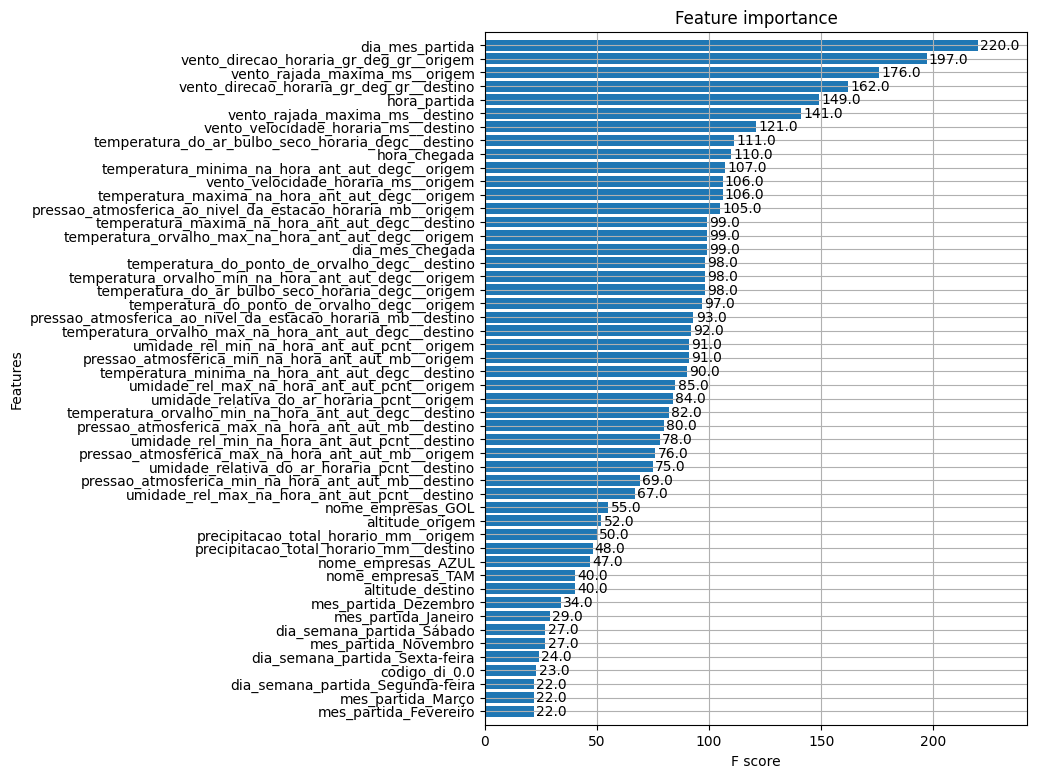

CPU times: total: 1.73 s
Wall time: 414 ms


In [17]:
%%time
fig, ax = plt.subplots(figsize=(7,9))
xgb.plot_importance(model_xgb, max_num_features=50, height=0.8, ax=ax)
plt.show()

### Treeplot XGBOOST

O XGBoost nos permite visualizar a árvore de decisão para compreender melhor o caminho seguido por ele. <br>

Sobre o algoritmo:<br>
https://www.youtube.com/watch?v=OtD8wVaFm6E (Parte 1)<br>
https://www.youtube.com/watch?v=8b1JEDvenQU (Parte 2)<br>


In [18]:
%%time
# plot single tree
#fig, ax = plt.subplots(figsize=(100, 100))
#fig = plt.figure(figsize=(12, 6))
plt.figure(figsize=(50, 50))
plot_tree(model_xgb)
plt.savefig('xgb_treeplot.jpg', dpi=1800)  
plt.show()

<Figure size 5000x5000 with 0 Axes>

CPU times: total: 2.73 s
Wall time: 4.09 s


## CatBoost

Diferentemente do XGBoost, o CatBoost não passou por one hot encoding, logo as informações agrupadas nos permite compreender melhor o peso de cada categoria. Algo que até o momento só o teste de qui-quadrado permitiu

In [19]:
%%time
feature_importance = model_ctb.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(15, 10))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

CPU times: total: 31.2 ms
Wall time: 47 ms


Text(0.5, 1.0, 'Feature Importance')

# Permutation importance

é uma técnica para determinar a importância das características em modelos de aprendizado de máquina. Ela é baseada na ideia de que a importância de uma característica pode ser medida observando-se o efeito da aleatorização<br>

Funcionamento:<br>

- Permutação de Características: Em seguida, para cada característica, você altera a ordem dos valores dessa característica no conjunto de dados (ou seja, você permuta os valores da característica).<br>

- Avaliação do Impacto: O modelo é então avaliado novamente com os dados alterados. O impacto na performance do modelo (como a acurácia, por exemplo) é medido.<br>

- Comparação com os Dados Originais: A diferença na performance do modelo entre os dados originais e os dados com a característica permutada indica a importância dessa característica. Uma grande diminuição na performance sugere que a característica é importante.<br>

É uma técnica mais robusta do que a feature importance, porém apresenta um custo computacional maior dado que acontece o processo de permutação. Em alguns casos, a permutação de características pode introduzir ruído que não reflete a realidade, especialmente em conjuntos de dados menores ou desbalanceados. Portanto ao analisarmos o resutlado temos que ter consciência que nossos dados estão desbalanceados. <br>

Neste contexto o resultado analisado será com o objetivo de corroborar com os demais resultados do processo de feature selection. <br>

## XGBoost

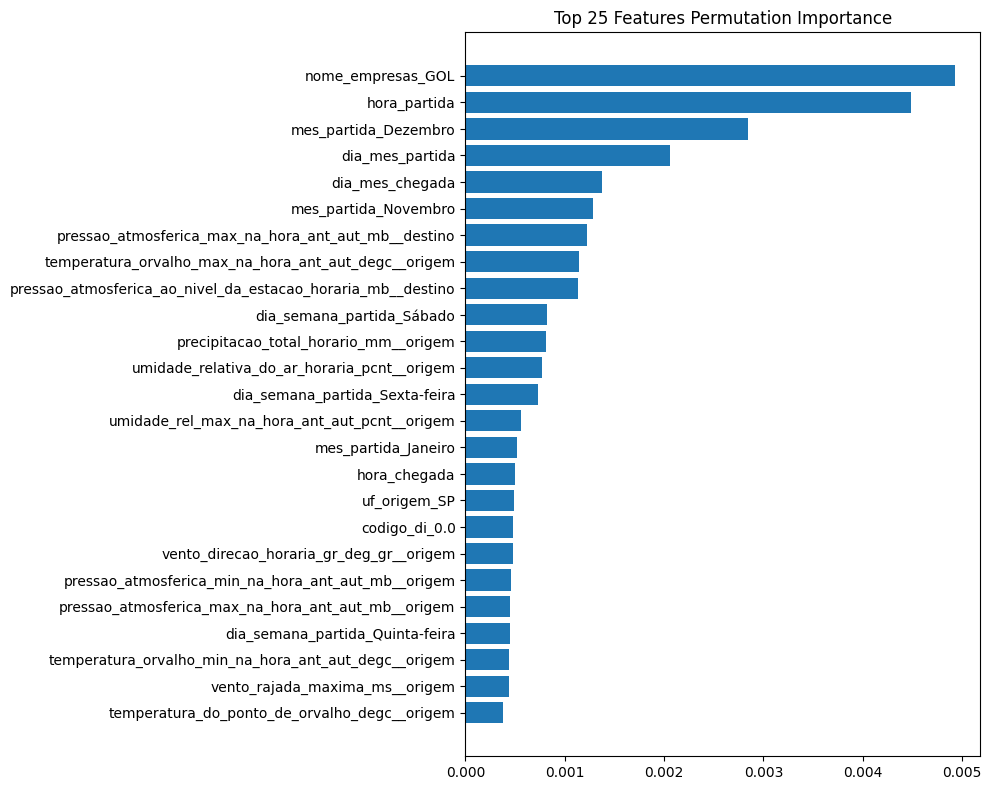

CPU times: total: 3h 2min 31s
Wall time: 1h 3min 5s


In [20]:
%%time
perm_importance = permutation_importance(model_xgb, X_test_hot, y_test_hot, n_repeats=10, random_state=123)

top_n = 25
# Ordenando as características pela importância e selecionando as top_n
sorted_idx = perm_importance.importances_mean.argsort()[-top_n:]

# Criando o gráfico de barras horizontal
plt.figure(figsize=(10, 8))  # Ajuste o tamanho conforme necessário
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')

# Definindo os y-ticks para serem os nomes das características
plt.yticks(range(len(sorted_idx)), np.array(X_test_hot.columns)[sorted_idx])

# Título do gráfico
plt.title('Top {} Features Permutation Importance'.format(top_n))

# Layout apertado para arranjo visual limpo
plt.tight_layout()

# Mostrar o gráfico
plt.show()

## CatBoost

CPU times: total: 5min 46s
Wall time: 2min


Text(0.5, 1.0, 'Permutation Importance')

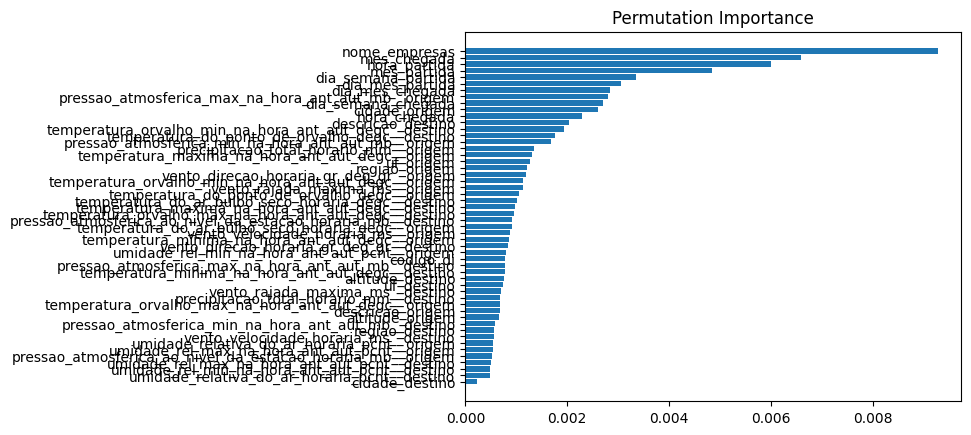

In [21]:
%%time
perm_importance = permutation_importance(model_ctb, X_test, y_test, n_repeats=10, random_state=123)
sorted_idx = perm_importance.importances_mean.argsort()
#fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Permutation Importance')


# Shap

SHAP (SHapley Additive exPlanations) é uma abordagem avançada para explicar as previsões de modelos de aprendizado de máquina. Baseia-se na teoria dos jogos, especificamente no conceito de valores de Shapley, para atribuir a cada característica um valor que indica a sua importância na previsão feita por um modelo. Em termos de ML, eles ajudam a determinar o quanto cada característica contribui para a previsão, considerando todas as combinações possíveis de características.<br>

Cálculo dos Valores SHAP: Para cada previsão, os valores SHAP atribuem a cada característica um valor que representa o seu impacto na mudança da previsão, em comparação com a previsão média para o dataset. Se uma característica aumenta a previsão, seu valor SHAP será positivo; se a diminui, será negativo. <br>

Em outras palavras o valor Shapley é a média (ponderada) das contribuições marginais <br>

A interpretação do valor de Shap ley é: Dado o conjunto atual de valores de recurso, a contribuição de um valor de recurso para a diferença entre a previsão real e a previsão média é o valor de Shap ley estimado.

https://github.com/shap/shap<br>
https://christophm.github.io/interpretable-ml-book/shapley.html<br>

## XGBoost

In [22]:
%%time
explainer = shap.Explainer(model_xgb)
shap_values = explainer(X_test_hot)
shap_importance = shap_values.abs.mean(0).values
sorted_idx = shap_importance.argsort()
#fig = plt.figure(figsize=(22, 21))
#plt.barh(range(len(sorted_idx)), shap_importance[sorted_idx], align='center')
#plt.yticks(range(len(sorted_idx)), np.array(X_test_hot.columns)[sorted_idx])
#plt.title('SHAP Importance')
shap.plots.bar(shap_values, max_display=35)

CPU times: total: 2min 20s
Wall time: 1min 1s


## CatBoost

In [23]:
%%time
explainer = shap.Explainer(model_ctb)
shap_values = explainer(dt_ax)
shap_importance = shap_values.abs.mean(0).values
sorted_idx = shap_importance.argsort()
fig = plt.figure(figsize=(14, 12))
shap.plots.bar(shap_values, max_display=dt_ax.shape[0])

CPU times: total: 27.6 s
Wall time: 24.1 s


# PCA (Objetivo: Reduzir Dimensionalidade)

## Umidade Origem

In [10]:
# Selecionando as colunas relevantes para a PCA
colunas_pca = [
    'umidade_rel_max_na_hora_ant_aut_pcnt__origem',
    'umidade_rel_min_na_hora_ant_aut_pcnt__origem',
    'umidade_relativa_do_ar_horaria_pcnt__origem'
]
df_pca = df[colunas_pca]

# Padronizando os dados para a PCA
scaler = StandardScaler()
df_pca_scaled = scaler.fit_transform(df_pca)

# Aplicando a PCA
pca = PCA(n_components=1)  # Exemplo: reduzindo para 2 componentes
componentes_principais = pca.fit_transform(df_pca_scaled)

# Adicionando os componentes principais ao DataFrame original
df['Componente_principal_umidade_origem'] = componentes_principais[:, 0]

## Vento Origem

In [11]:
# Selecionando as colunas relevantes para a PCA
colunas_pca = [
'vento_direcao_horaria_gr_deg_gr__origem',
 'vento_rajada_maxima_ms__origem',
 'vento_velocidade_horaria_ms__origem',
]
df_pca = df[colunas_pca]

# Padronizando os dados para a PCA
scaler = StandardScaler()
df_pca_scaled = scaler.fit_transform(df_pca)

# Aplicando a PCA
pca = PCA(n_components=1)  # Exemplo: reduzindo para 2 componentes
componentes_principais = pca.fit_transform(df_pca_scaled)

# Adicionando os componentes principais ao DataFrame original
df['Componente_principal_vento_origem'] = componentes_principais[:, 0]

## Umidade Destino

In [12]:
# Selecionando as colunas relevantes para a PCA
colunas_pca = [
 'umidade_rel_max_na_hora_ant_aut_pcnt__destino',
 'umidade_rel_min_na_hora_ant_aut_pcnt__destino',
 'umidade_relativa_do_ar_horaria_pcnt__destino',
]
df_pca = df[colunas_pca]

# Padronizando os dados para a PCA
scaler = StandardScaler()
df_pca_scaled = scaler.fit_transform(df_pca)

# Aplicando a PCA
pca = PCA(n_components=1)  # Exemplo: reduzindo para 2 componentes
componentes_principais = pca.fit_transform(df_pca_scaled)

# Adicionando os componentes principais ao DataFrame original
df['componente_principal_umidade_destino'] = componentes_principais[:, 0]

## Vento Destino

In [13]:
# Selecionando as colunas relevantes para a PCA
colunas_pca = [
 'vento_direcao_horaria_gr_deg_gr__destino',
 'vento_rajada_maxima_ms__destino',
 'vento_velocidade_horaria_ms__destino',
]
df_pca = df[colunas_pca]

# Padronizando os dados para a PCA
scaler = StandardScaler()
df_pca_scaled = scaler.fit_transform(df_pca)

# Aplicando a PCA
pca = PCA(n_components=1)  # Exemplo: reduzindo para 2 componentes
componentes_principais = pca.fit_transform(df_pca_scaled)

# Adicionando os componentes principais ao DataFrame original
df['componente_principal_vento_destino'] = componentes_principais[:, 0]

## Salvando dataframe com dimensões reduzidas

In [18]:
df_pca = df[['nome_empresas', 
 'cidade_origem', 'uf_origem', 'regiao_origem', 
 'cidade_destino', 'uf_destino', 'regiao_destino',
 'codigo_di',
 'descricao_origem', 'descricao_destino', 
 'status_do_voo',
 'hora_partida', 'mes_partida', 'dia_semana_partida', 'dia_mes_partida',
 'hora_chegada', 'mes_chegada', 'dia_semana_chegada', 'dia_mes_chegada',
 'altitude_origem', 'altitude_destino',
'precipitacao_total_horario_mm__origem',
 'pressao_atmosferica_ao_nivel_da_estacao_horaria_mb__origem', 'pressao_atmosferica_max_na_hora_ant_aut_mb__origem', 'pressao_atmosferica_min_na_hora_ant_aut_mb__origem',
 'temperatura_do_ar_bulbo_seco_horaria_degc__origem', 'temperatura_do_ponto_de_orvalho_degc__origem', 'temperatura_maxima_na_hora_ant_aut_degc__origem',
 'temperatura_minima_na_hora_ant_aut_degc__origem', 'temperatura_orvalho_max_na_hora_ant_aut_degc__origem', 'temperatura_orvalho_min_na_hora_ant_aut_degc__origem',
 'precipitacao_total_horario_mm__destino',
 'pressao_atmosferica_ao_nivel_da_estacao_horaria_mb__destino', 'pressao_atmosferica_max_na_hora_ant_aut_mb__destino', 'pressao_atmosferica_min_na_hora_ant_aut_mb__destino',
 'temperatura_do_ar_bulbo_seco_horaria_degc__destino', 'temperatura_do_ponto_de_orvalho_degc__destino', 'temperatura_maxima_na_hora_ant_aut_degc__destino',
 'temperatura_minima_na_hora_ant_aut_degc__destino', 'temperatura_orvalho_max_na_hora_ant_aut_degc__destino', 'temperatura_orvalho_min_na_hora_ant_aut_degc__destino',
 'Componente_principal_umidade_origem',
 'Componente_principal_vento_origem',
 'componente_principal_umidade_destino',
 'componente_principal_vento_destino']]

In [19]:
# Definir o caminho do diretório e do arquivo CSV
diretorio = 'dados_tratados'
nome_arquivo = 'historico_voo_tratados_train_df_pca.csv'
caminho_completo = os.path.join(diretorio, nome_arquivo)
df_pca.to_csv(caminho_completo, index=False)

# PCA (Objetivo: Seleção de variaveis)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


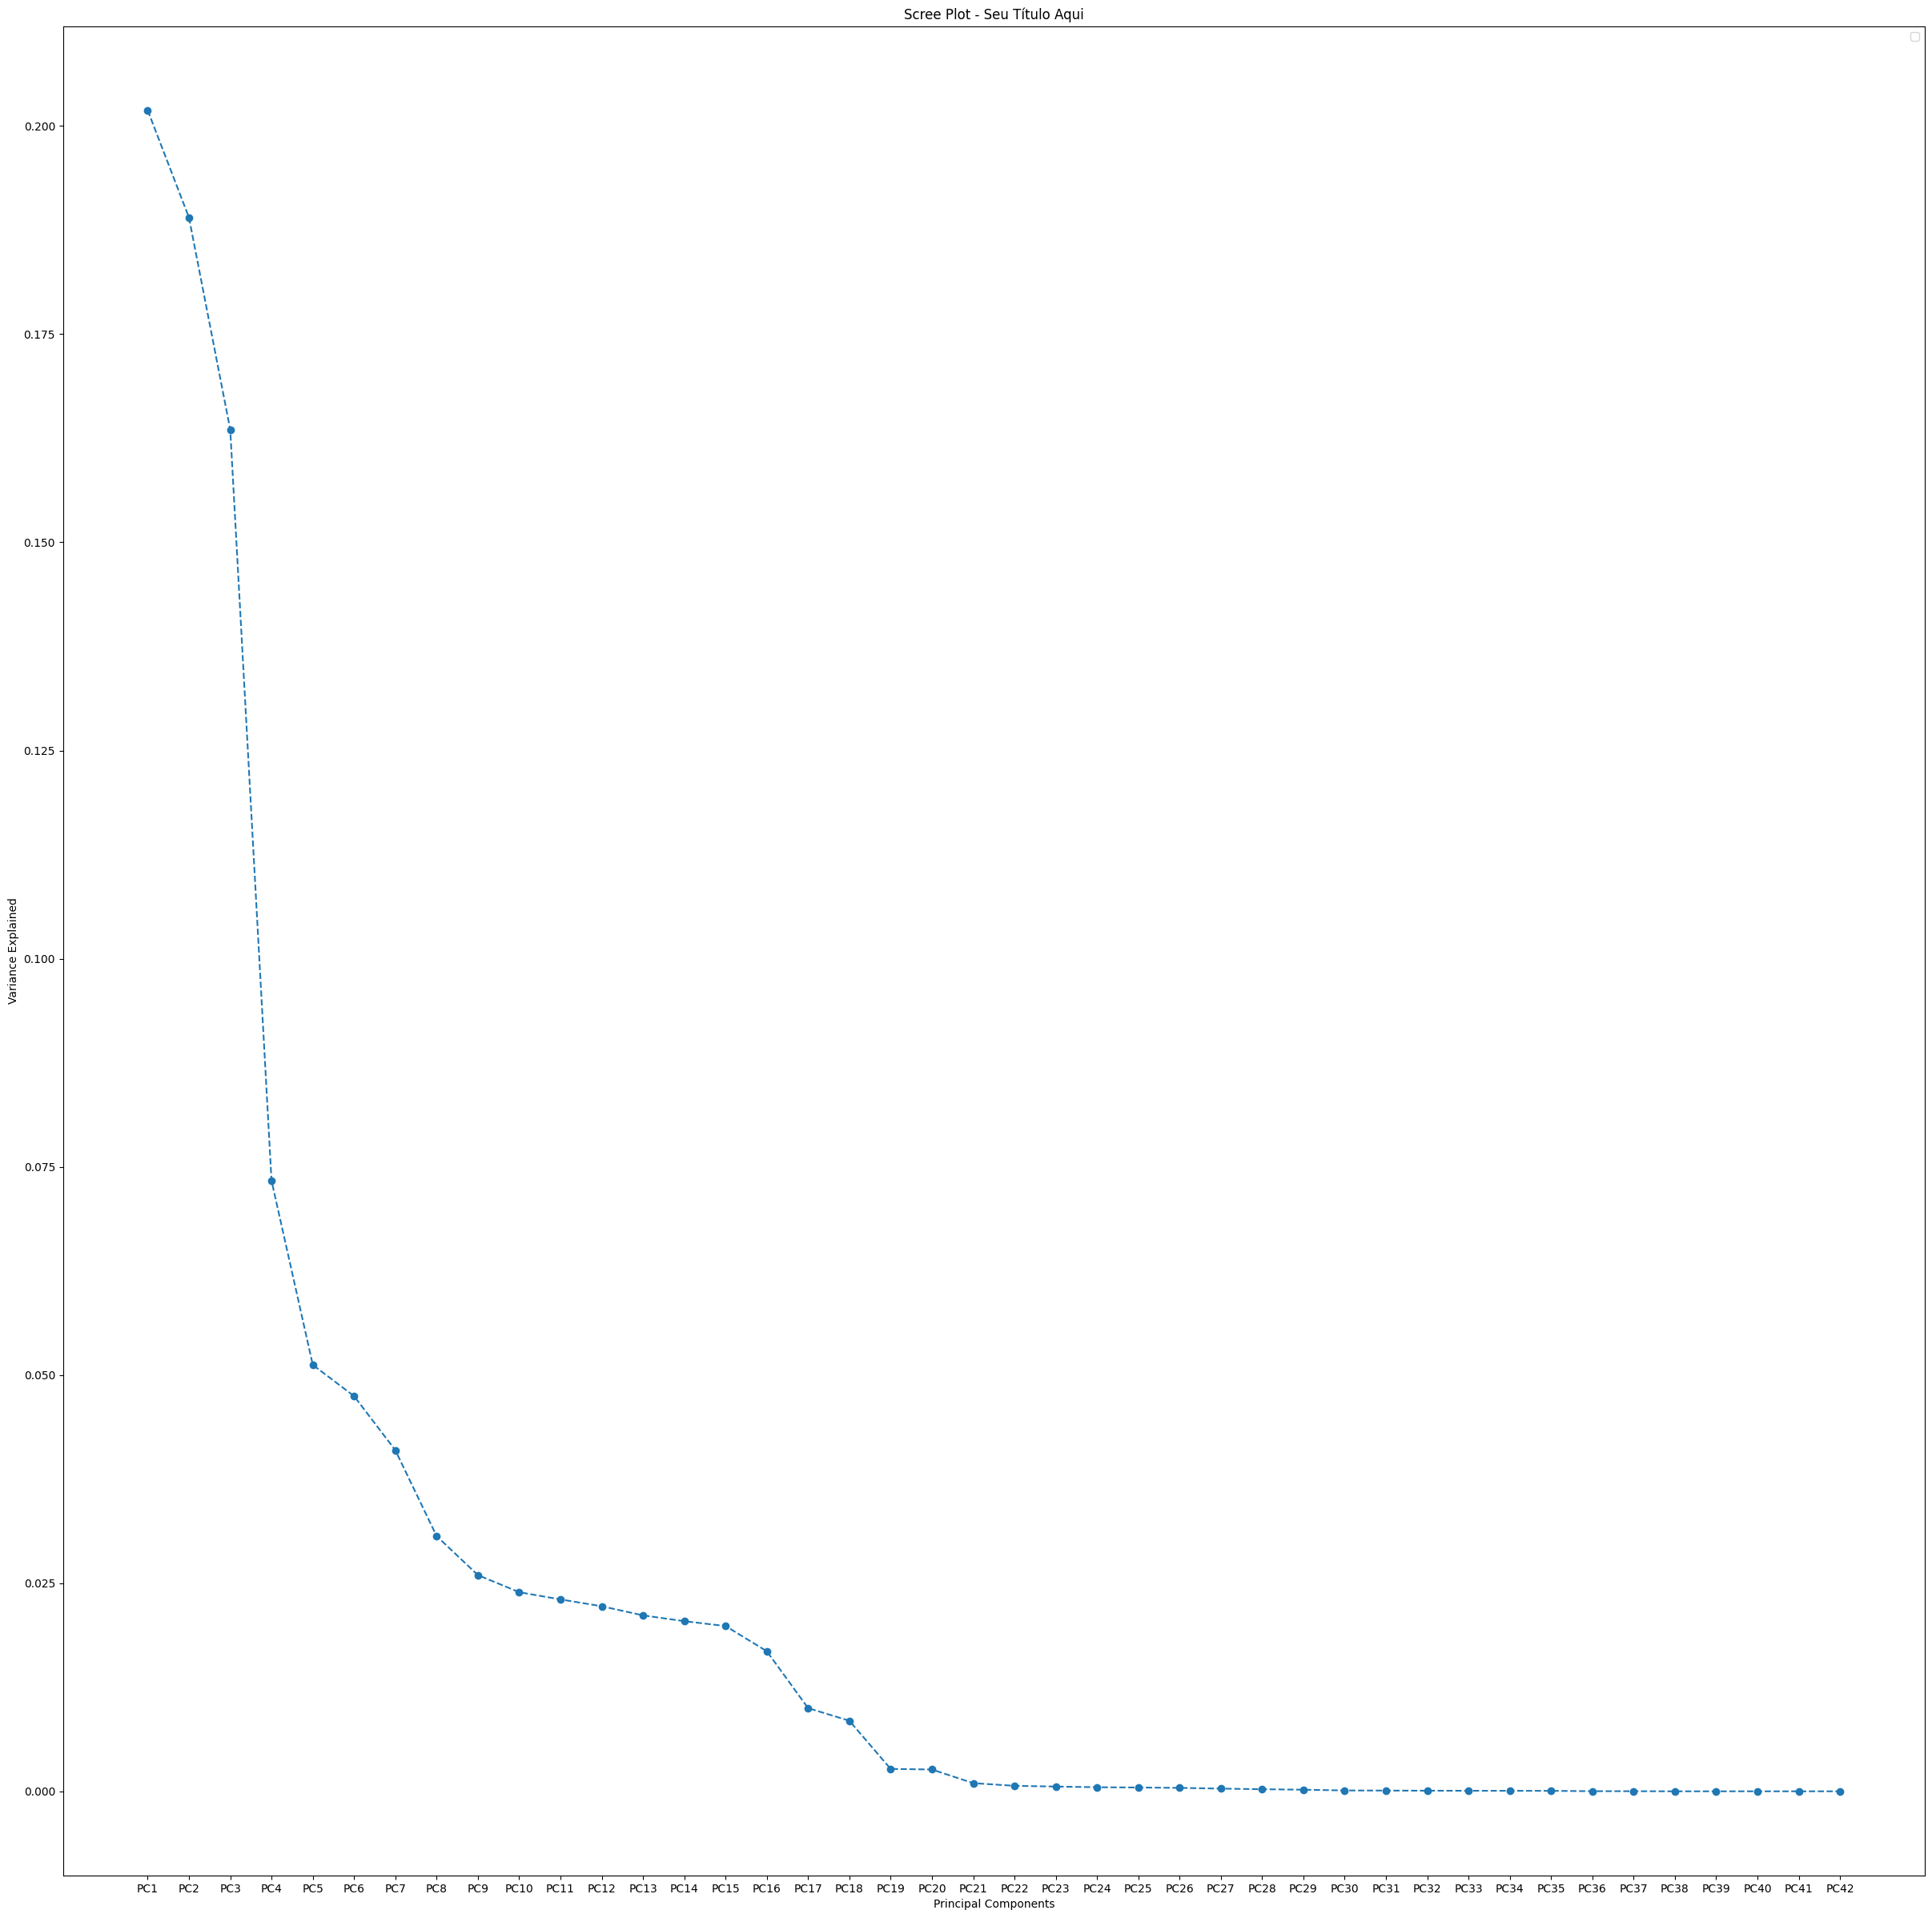

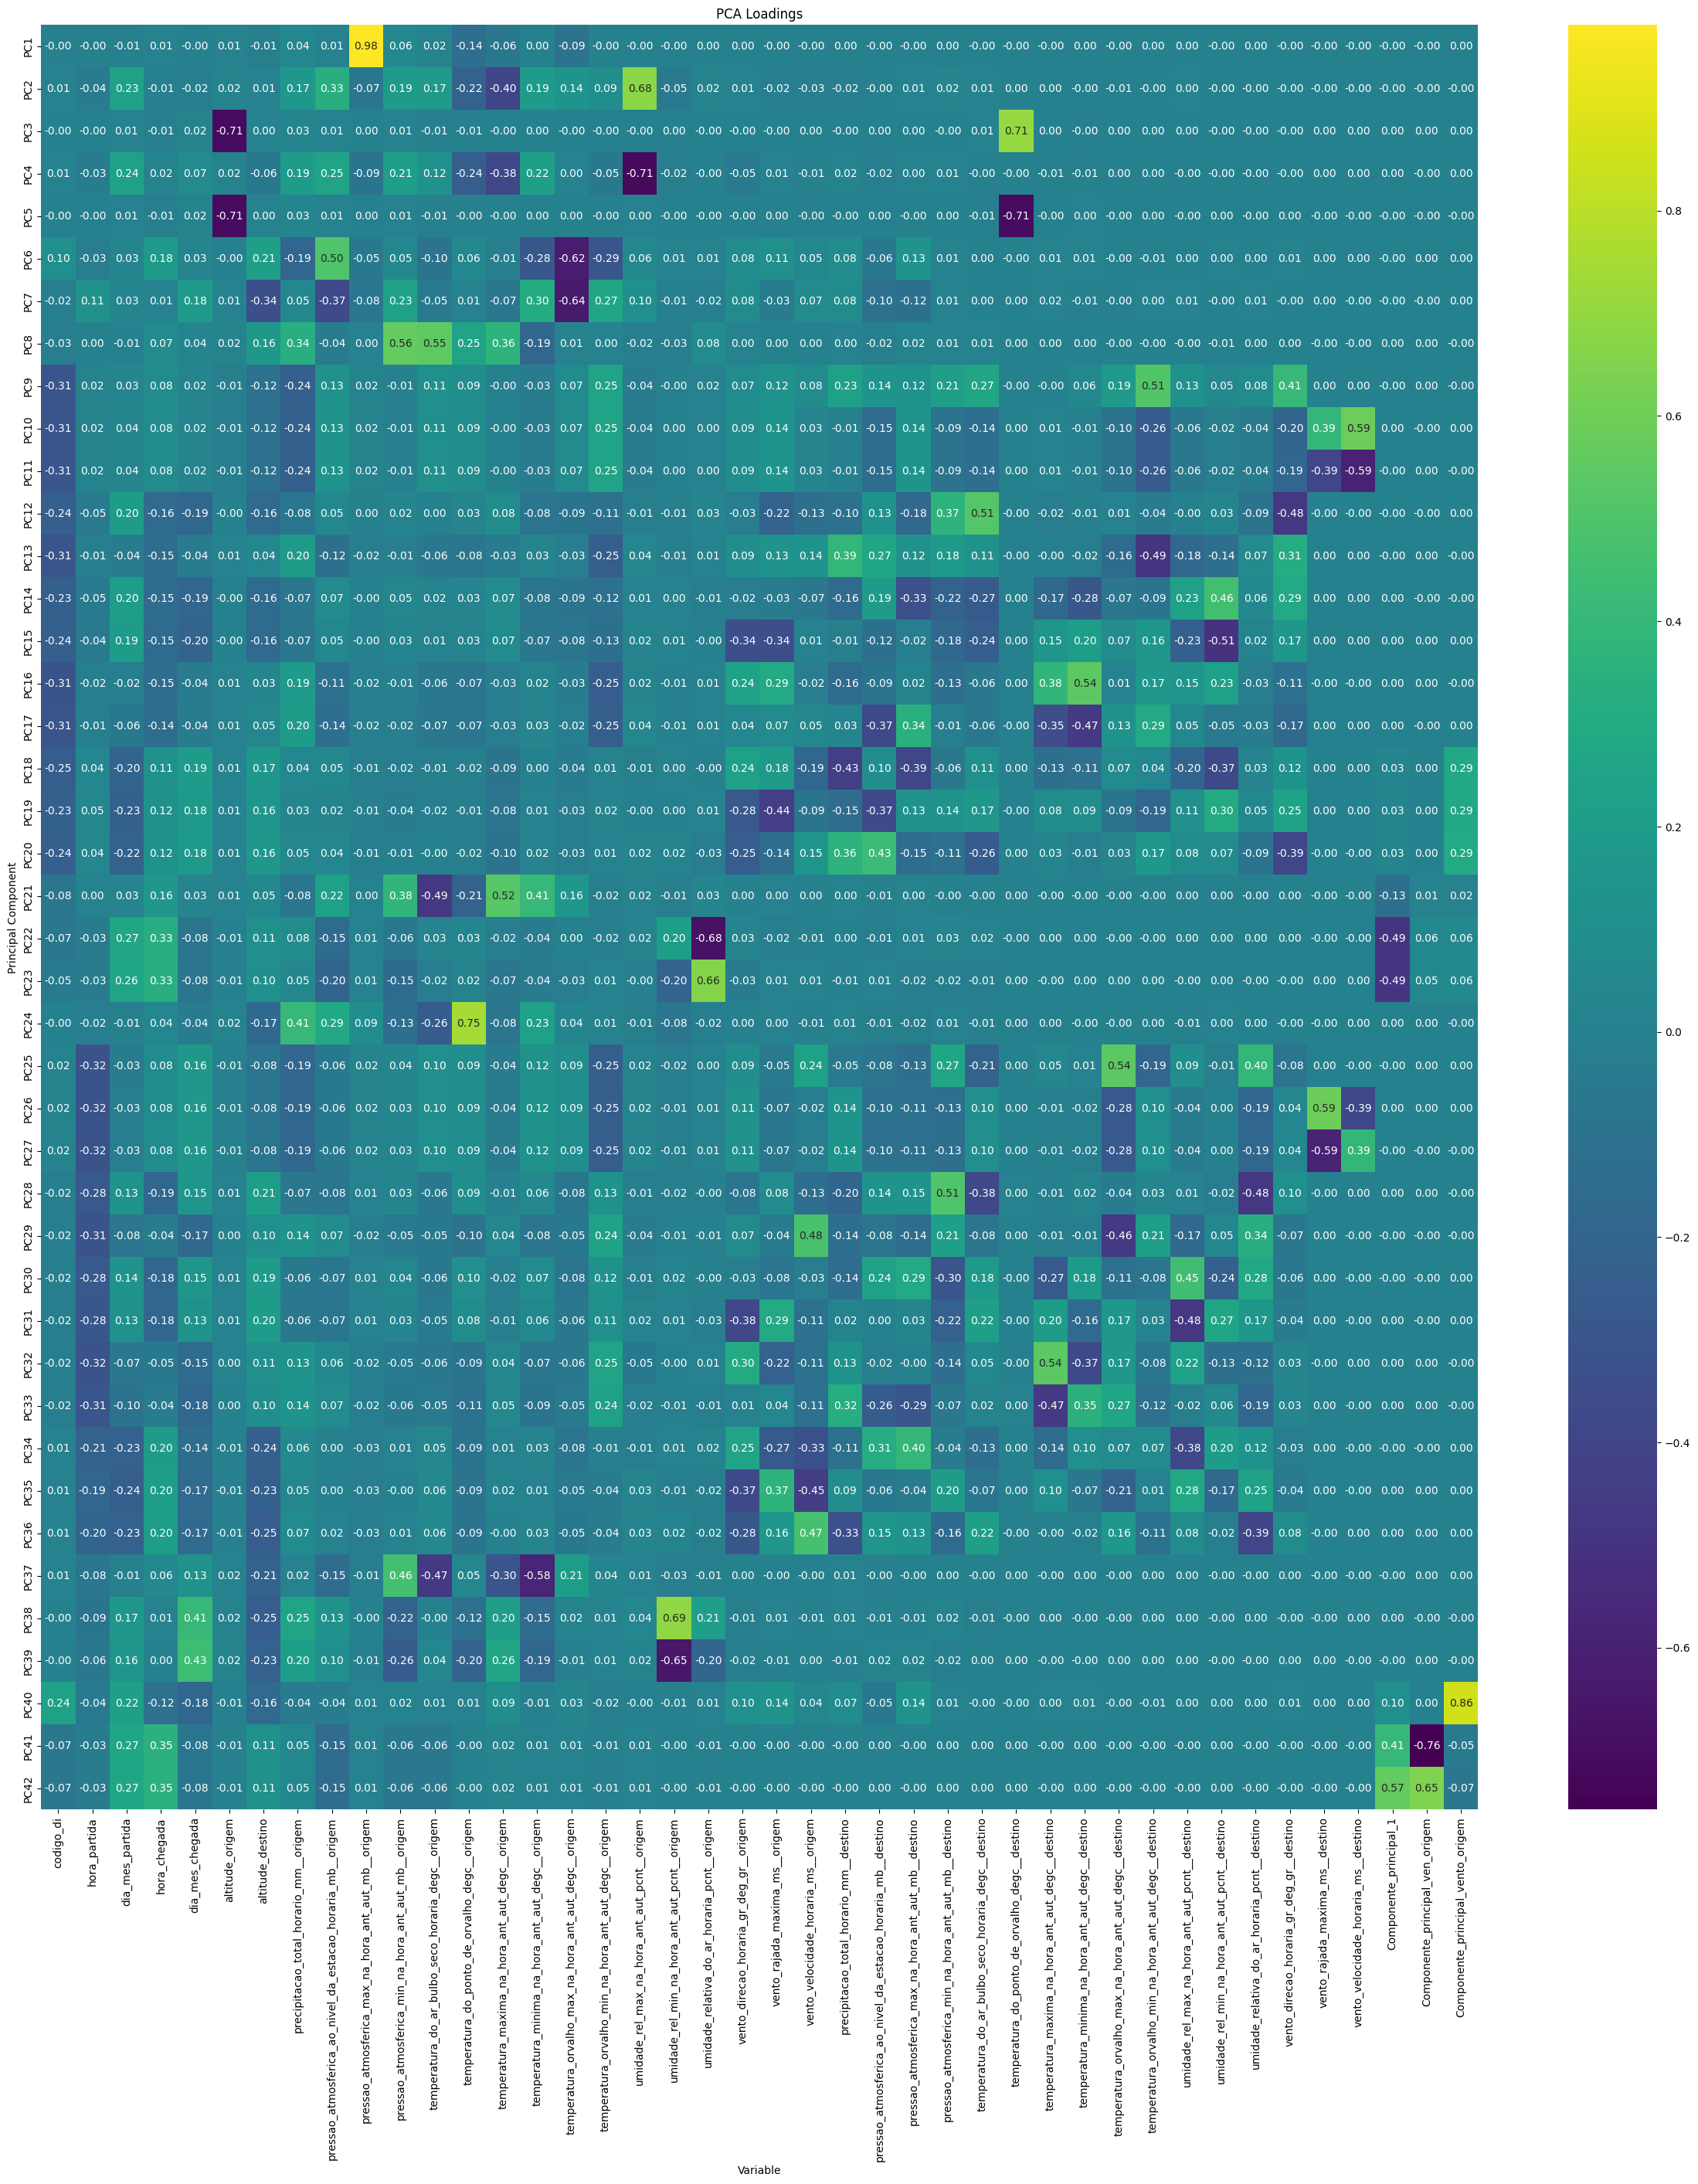

In [117]:
# Substitua 'df' pelo seu DataFrame
# Selecionando colunas numéricas
colunas_numericas = df.select_dtypes(include=['float64', 'int64']).columns
df_numeric = df[colunas_numericas]

# Padronizando os dados
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric)

# Aplicando a PCA
pca = PCA()
componentes_principais = pca.fit_transform(df_scaled)

# Variância explicada por cada componente
explained_variance = pca.explained_variance_ratio_

# Loadings são os coeficientes dos componentes principais
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(len(df_numeric.columns))], index=df_numeric.columns)

# Agora, chamando as funções para gerar os gráficos
plot_scree_plot(explained_variance)
plot_loadings(loadings)
plot_loadings_heatmap(loadings, loadings.columns, loadings.index)
